# House Price Prediction


**Table of contents**<a id='toc0_'></a>

- 1. [Data Preparation](#toc1_)
  - 1.1. [Data Collection & Ingestion](#toc1_1_)
  - 1.2. [Data Cleaning](#toc1_2_)
- 2. [Exploratory Data Analysis](#toc2_)
  - 2.1. [Univariate Analysis](#toc2_1_)
    - 2.1.1. [Numerical Columns](#toc2_1_1_)
    - 2.1.2. [Binary columns](#toc2_1_2_)
    - 2.1.3. [Categorical columns](#toc2_1_3_)
  - 2.2. [Bivariate/Multivariate Analysis](#toc2_2_)
    - 2.2.1. [Numerical values](#toc2_2_1_)
- 3. [Feature Engineering](#toc3_)
  - 3.1. [Transformations & Encoding](#toc3_1_)
    - 3.1.1. [Handling skewness in numerical columns](#toc3_1_1_)
    - 3.1.2. [Numerical values standardization](#toc3_1_2_)
    - 3.1.3. [Convert boolean columns to 0/1 encoding](#toc3_1_3_)
  - 3.2. [One-hot encoding for categorical values](#toc3_2_)

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


In [211]:
from typing import List

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler

## 1. <a id='toc1_'></a>[Data Preparation](#toc0_)


### 1.1. <a id='toc1_1_'></a>[Data Collection & Ingestion](#toc0_)


In [212]:
dataset = pd.read_csv("./data/Housing.csv")
dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [213]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [214]:
dataset.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


### 1.2. <a id='toc1_2_'></a>[Data Cleaning](#toc0_)


In [215]:
dataset.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [216]:
dataset.duplicated().sum()

np.int64(0)

## 2. <a id='toc2_'></a>[Exploratory Data Analysis](#toc0_)


### 2.1. <a id='toc2_1_'></a>[Univariate Analysis](#toc0_)


#### 2.1.1. <a id='toc2_1_1_'></a>[Numerical Columns](#toc0_)


In [217]:
numerical_columns = ["price", "area"]

Skwness of price feature


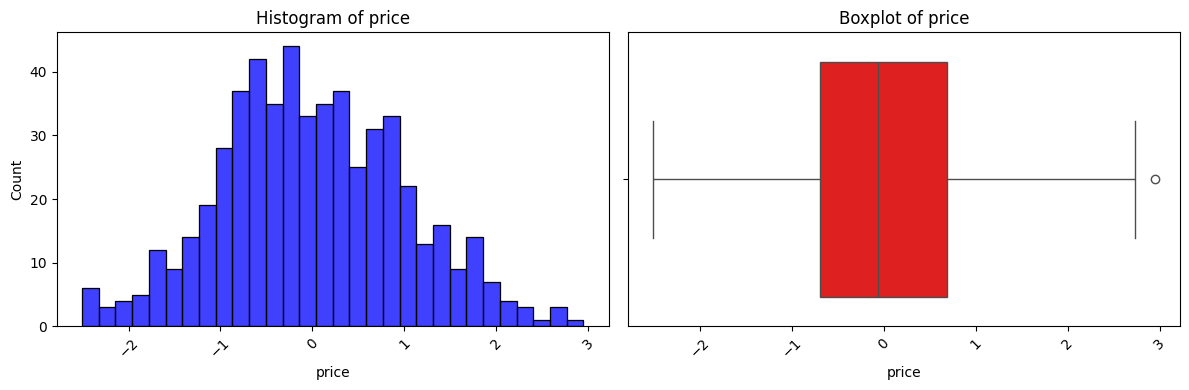

Skwness of area feature


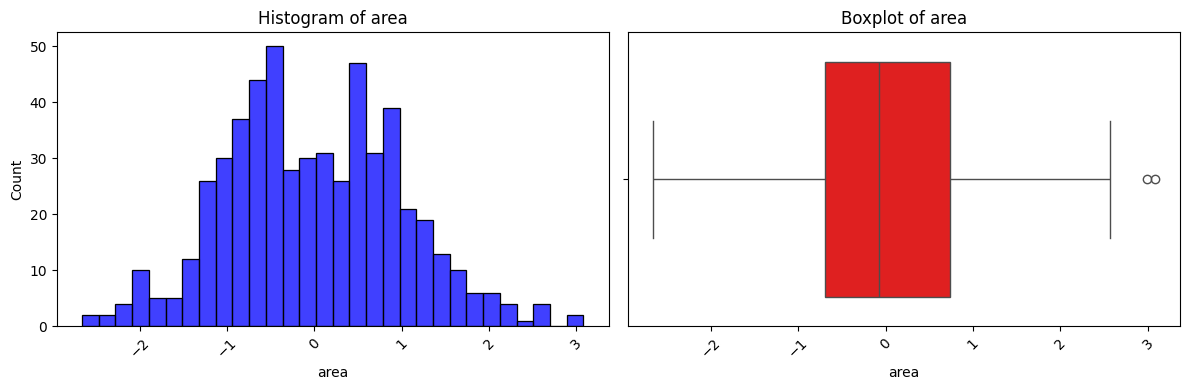

In [232]:
def plot_numerical_columns(dataset: pd.DataFrame, numerical_columns: List[str]) -> None:
    for col in numerical_columns:
        _, axes = plt.subplots(1, 2, figsize=(12, 4))
        skewness = dataset[col].skew()
        print(f"Skwness of {col} feature: {skewness}")

        sns.histplot(dataset[col], bins=30, ax=axes[0], color="blue")
        axes[0].set_title(f"Histogram of {col}")
        axes[0].ticklabel_format(style="plain")
        axes[0].tick_params(axis="x", rotation=45)

        sns.boxplot(x=dataset[col], ax=axes[1], color="red")
        axes[1].set_title(f"Boxplot of {col}")
        axes[1].xaxis.set_major_formatter(ScalarFormatter())
        axes[1].tick_params(axis="x", rotation=45)
        axes[1].ticklabel_format(style="plain", axis="x")
        axes[1].xaxis.get_offset_text().set_visible(False)

        plt.tight_layout()
        plt.show()


plot_numerical_columns(dataset, numerical_columns)

#### 2.1.2. <a id='toc2_1_2_'></a>[Binary columns](#toc0_)


In [219]:
binary_columns = [
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "prefarea",
]

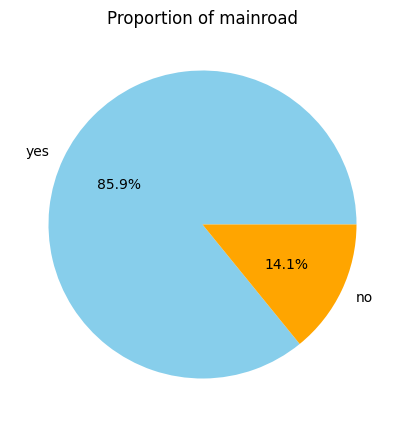

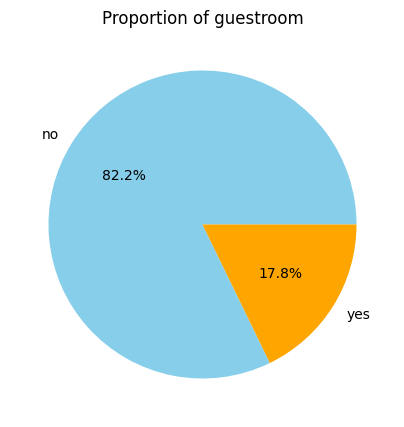

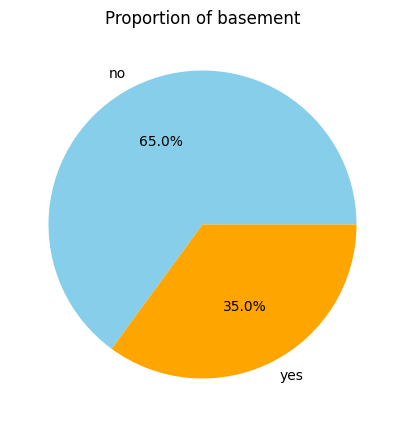

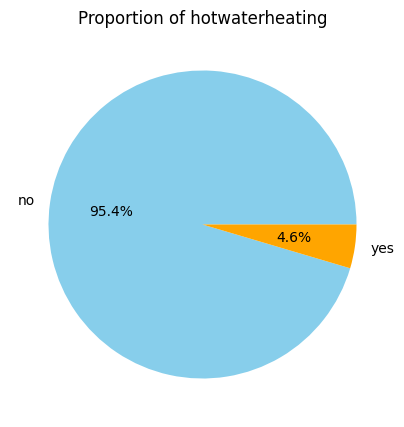

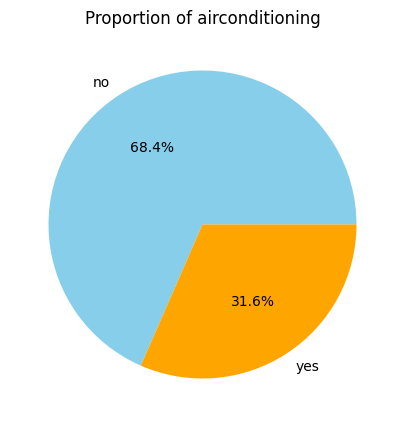

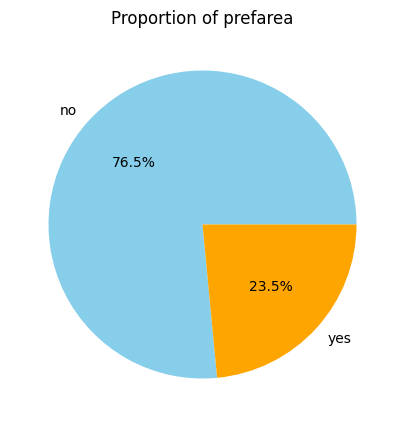

In [220]:
def plot_binary_columns(dataset: pd.DataFrame, binary_columns: List[str]) -> None:
    for col in binary_columns:
        plt.figure(figsize=(5, 5))
        dataset[col].value_counts().plot.pie(
            autopct="%1.1f%%", colors=["skyblue", "orange"]
        )
        plt.title(f"Proportion of {col}")
        plt.ylabel("")
        plt.show()


plot_binary_columns(dataset, binary_columns)

#### 2.1.3. <a id='toc2_1_3_'></a>[Categorical columns](#toc0_)


In [221]:
categorical_columns = [
    "bedrooms",
    "bathrooms",
    "stories",
    "parking",
    "furnishingstatus",
]

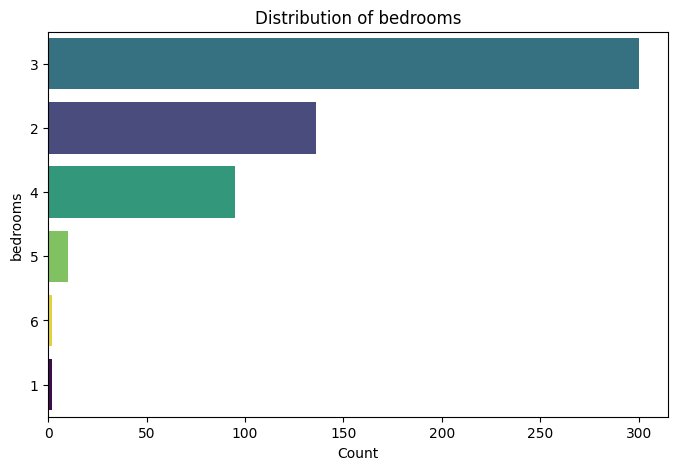

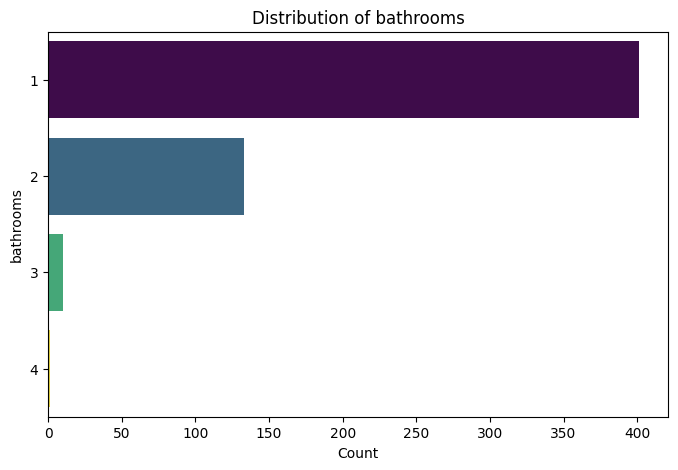

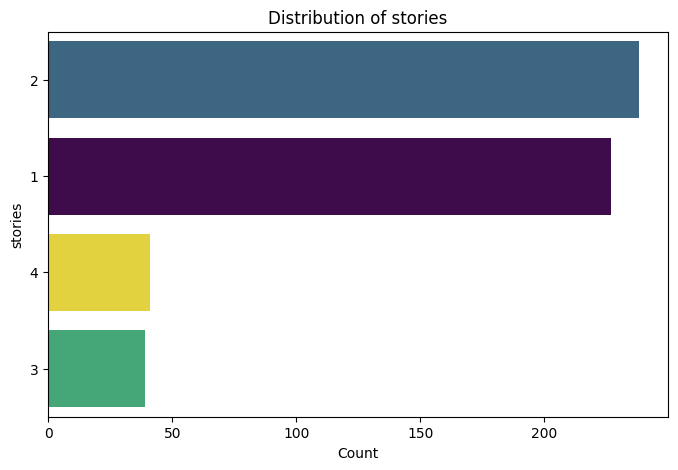

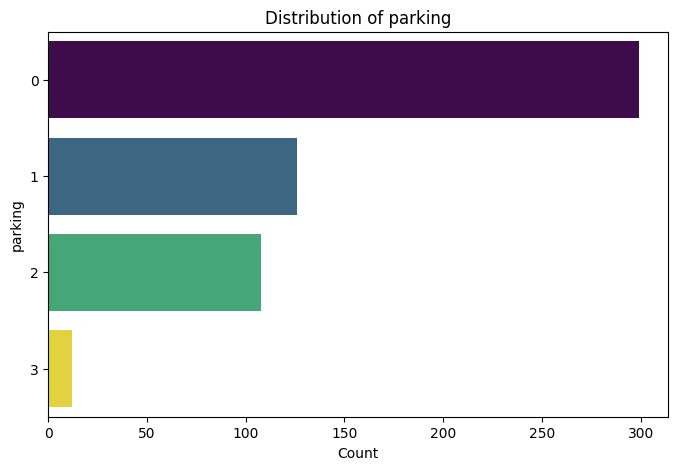

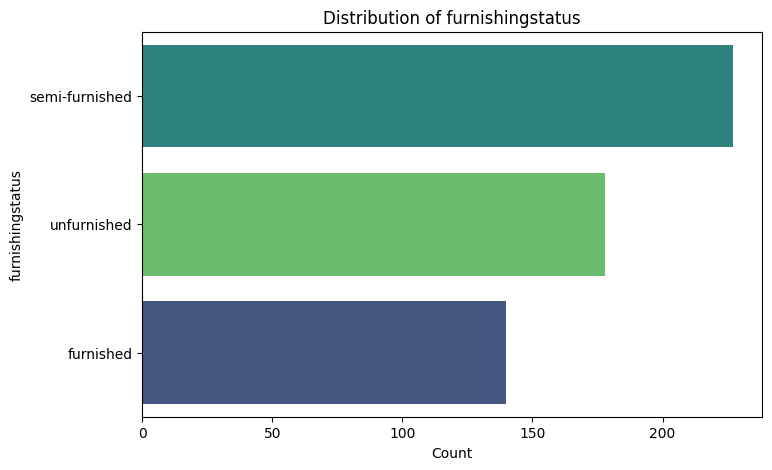

In [222]:
def plot_categorical_columns(
    dataset: pd.DataFrame, categorical_columns: List[str]
) -> None:
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(
            y=dataset[col],
            hue=dataset[col],
            legend=False,
            order=dataset[col].value_counts().index,
            palette="viridis",
        )
        plt.title(f"Distribution of {col}")
        plt.xlabel("Count")
        plt.ylabel(col)
        plt.show()


plot_categorical_columns(dataset, categorical_columns)

### 2.2. <a id='toc2_2_'></a>[Bivariate/Multivariate Analysis](#toc0_)


#### 2.2.1. <a id='toc2_2_1_'></a>[Numerical values](#toc0_)


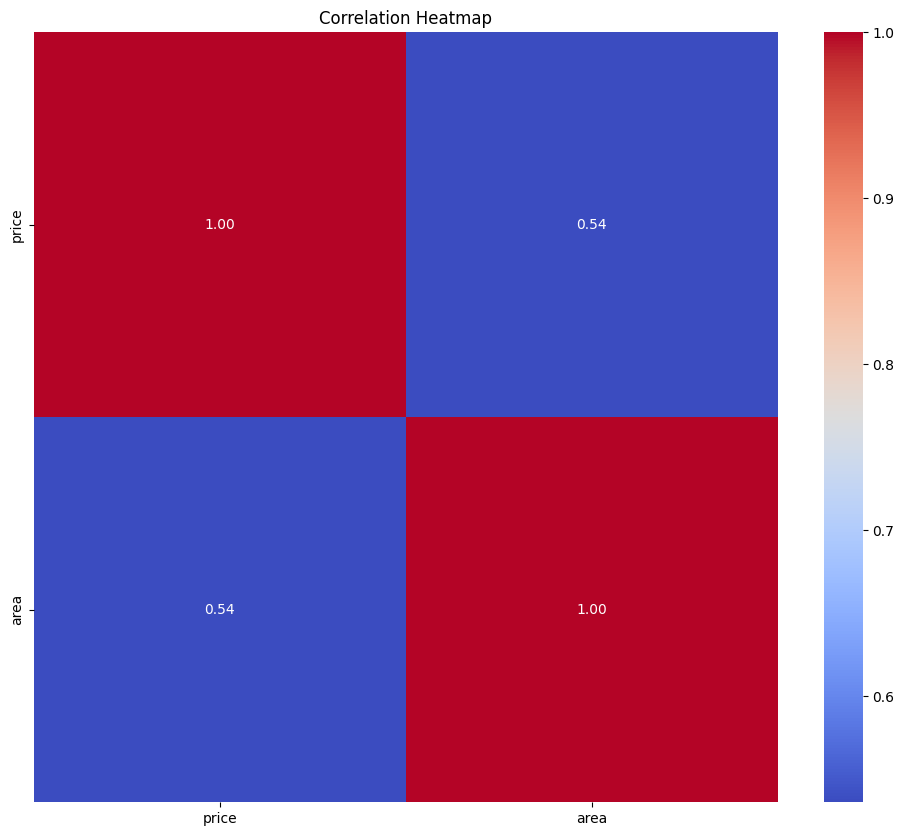

In [223]:
numerical_columns_dataset = dataset[numerical_columns].copy()

plt.figure(figsize=(12, 10))
sns.heatmap(numerical_columns_dataset.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

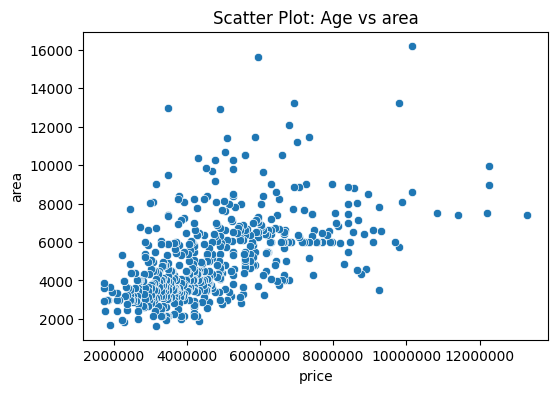

In [224]:
for col in numerical_columns_dataset.columns:
    if col != "price":
        plt.figure(figsize=(6, 4))
        plt.ticklabel_format(style="plain")
        sns.scatterplot(
            x=numerical_columns_dataset["price"],
            y=numerical_columns_dataset[col],
        )
        plt.title(f"Scatter Plot: Age vs {col}")
        plt.show()

## 3. <a id='toc3_'></a>[Feature Engineering](#toc0_)


### 3.1. <a id='toc3_1_'></a>[Transformations & Encoding](#toc0_)


#### 3.1.1. <a id='toc3_1_1_'></a>[Handling skewness in numerical columns](#toc0_)


0.14086281102108905


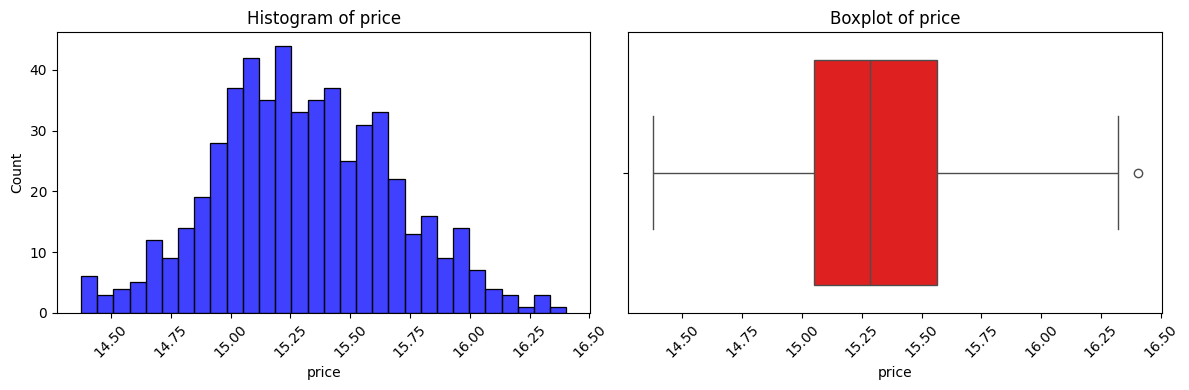

0.13374740415416703


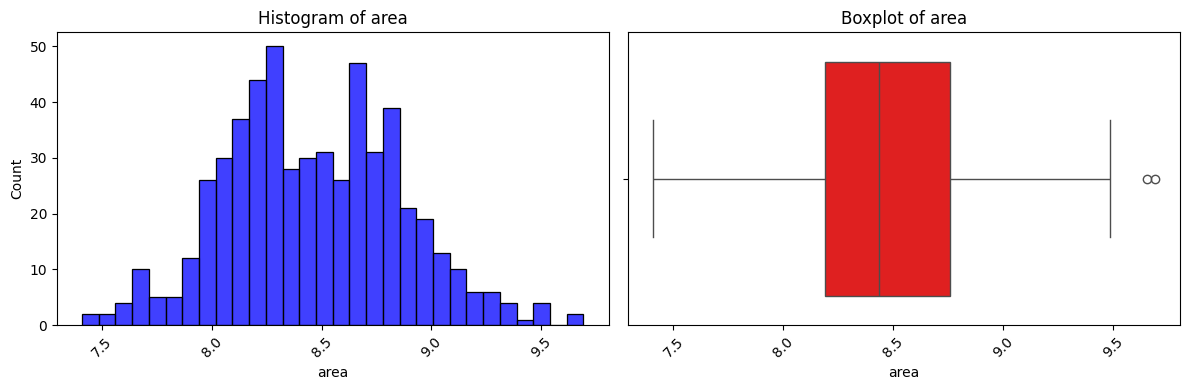

In [225]:
def transform_skewed_columns(
    dataset: pd.DataFrame, numerical_columns: List[str]
) -> pd.DataFrame:
    for col in numerical_columns:
        skewness = dataset[col].skew()
        if skewness > 1:
            dataset[col] = np.log1p(dataset[col])
    return dataset


dataset = transform_skewed_columns(dataset, numerical_columns)
plot_numerical_columns(dataset, numerical_columns)

#### 3.1.2. <a id='toc3_1_2_'></a>[Numerical values standardization](#toc0_)


In [226]:
scaler = StandardScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,2.948408,1.119332,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,2.727233,1.593323,4,4,4,yes,no,no,no,yes,3,no,furnished
2,2.727233,1.859255,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,2.719538,1.146285,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,2.536186,1.119332,4,1,2,yes,yes,yes,no,yes,2,no,furnished


#### 3.1.3. <a id='toc3_1_3_'></a>[Convert boolean columns to 0/1 encoding](#toc0_)


In [227]:
for col in binary_columns:
    dataset[col] = dataset[col].map({"yes": 1, "no": 0})

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,2.948408,1.119332,4,2,3,1,0,0,0,1,2,1,furnished
1,2.727233,1.593323,4,4,4,1,0,0,0,1,3,0,furnished
2,2.727233,1.859255,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,2.719538,1.146285,4,2,2,1,0,1,0,1,3,1,furnished
4,2.536186,1.119332,4,1,2,1,1,1,0,1,2,0,furnished


#### 3.2. <a id='toc3_2_'></a>[One-hot encoding for categorical values](#toc0_)


In [228]:
def one_hot_encode(
    dataset: pd.DataFrame, categorical_columns: List[str]
) -> pd.DataFrame:
    dataset = pd.get_dummies(dataset, columns=categorical_columns, dtype=int)

    return dataset


dataset = one_hot_encode(dataset, categorical_columns)

dataset.head()

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,bedrooms_1,bedrooms_2,...,stories_2,stories_3,stories_4,parking_0,parking_1,parking_2,parking_3,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,2.948408,1.119332,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,2.727233,1.593323,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,2.727233,1.859255,1,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
3,2.719538,1.146285,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,1,0,0
4,2.536186,1.119332,1,1,1,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [230]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            545 non-null    float64
 1   area                             545 non-null    float64
 2   mainroad                         545 non-null    int64  
 3   guestroom                        545 non-null    int64  
 4   basement                         545 non-null    int64  
 5   hotwaterheating                  545 non-null    int64  
 6   airconditioning                  545 non-null    int64  
 7   prefarea                         545 non-null    int64  
 8   bedrooms_1                       545 non-null    int64  
 9   bedrooms_2                       545 non-null    int64  
 10  bedrooms_3                       545 non-null    int64  
 11  bedrooms_4                       545 non-null    int64  
 12  bedrooms_5            